## LSTM class Developed
-----------------------------
[feat] 7/16
- ! to prevent overfitting use K-fold, validation split ! <- NEED TO DEVELOP
- basical LSTM model => lstm dense need to doubled
- not tested
- without AOC, interest rate
- bidirectional LSTM Model

[feat] 7/17

[need] 7/17
- val_loss 범위 설정
- k-fold 구현-> LSTM 구조상 폐기
- return값 설정
- 모델 예측 설정 방법


#### 7/19 V 1.0
[feat]
- postscale...      (done)
- model test res... (done)
- predict range .. (done) (using loss mean square err)

[need] 7/19 V 1.0
- prediction res return function => ??input??
-
[feat] V 1.0.1
- visiualization update
- check res (Request)

[feat] V 1.0.2
- loss calc func
- get tested output

#### 7/20
[feat & perf] V 1.1.0
- optimizated
- instanced model
- model complete

[need] V 1.1.0
- need to develop model quality
- sort & compedit gap values with prophet

if prophet is batter than LSTM use Prophet (by watching res)


--------------------------------------------------------
#### For ansj
- poltting testset
- batch = 500

imorts & get datas
------------

In [3]:
#!pip install -U finance-datareader

#%pip install FinanceDataReader

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense ,LSTM, Dropout,Bidirectional
from sklearn.model_selection import train_test_split, KFold
from tensorflow import expand_dims
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from os.path import join
from tensorflow import constant
from time import sleep
#import FinanceDataReader as fdr

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path="/content/drive/MyDrive/2023_1st_vac/KRX_DATA/train.csv" # path = dataset path(google drive)
data=pd.read_csv(path)

In [7]:
# prescaler
def getAOC(data):
  AOC = []
  close = data['종가']
  close_pre = close.shift(1)

  AOC.append(0)

  # aoc = (금일 종가 - 전일 종가) / 전일 종가
  for i in range(1, len(close)):
    aoc_value = ((close[i] - close_pre[i]) / close_pre[i]) * 100
    AOC.append(aoc_value)

  return AOC

#sort data by "종목명"
subject_Data=data.sort_values(by="종목명",inplace=False)
subject_Data.head()
subject_Data.columns

pv_s_data=pd.pivot_table(subject_Data,values=['거래량', '시가', '고가', '저가', '종가'],index=['종목코드','일자'])

divided = pv_s_data.index.get_level_values('종목코드').unique()

sliced_dataframes = []

for i in divided:
    sliced_data = pv_s_data.loc[i]
    sliced_dataframe = sliced_data.reset_index()
    sliced_dataframes.append(sliced_dataframe)

In [9]:
sliced_dataframes[0].columns[1:-1]

Index(['거래량', '고가', '시가', '저가'], dtype='object')

## LSTM Obj

In [10]:
class LSTM_Object():

  def __init__(self,data):
    #get sliced data
    self.data=data

  def modeling(self):

    self.prescale()
    self.model=Sequential()
    #layers
    self.model.add(Bidirectional(LSTM(1024,return_sequences=True,input_shape=(self.time_steps, self.num_features))))
    self.model.add(Dense(512, activation='relu'))
    self.model.add(Dense(256, activation='relu'))
    self.model.add(Dense(128, activation='relu'))
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dense(32, activation='relu'))

    model_save_path='/content/drive/MyDrive/2023_1st_vac/KRX_modelings/tests'

    #output layer
    self.model.add(Dense(1, activation='relu'))
    self.filename = join(model_save_path, 'ckeckpointer.ckpt')
    checkpoint = ModelCheckpoint(self.filename, save_weights_only=True, save_best_only=True,monitor='val_loss',verbose=0)

    earlystopping = EarlyStopping(monitor='val_loss', patience=100)
    self.model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=0.001))
    self.history=self.model.fit(self.x_train,self.y_train,epochs=500,batch_size=128,validation_data=(self.x_val,self.y_val),shuffle=False,callbacks=[checkpoint, earlystopping],verbose=0)


  def prescale(self):

    x_scaler = MinMaxScaler()
    self.y_scaler = MinMaxScaler()
    # Scaling features
    x_data = self.data[self.data.columns[1:-1]]
    x_data = x_scaler.fit_transform(x_data)
    # Scaling target variable
    y_data = self.data['종가']
    y_data = self.y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    # validation set
    x_train_p, x_test, y_train_p, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train_p, y_train_p, test_size=0.25, shuffle=False)
    __t,x_final,__t,__t=train_test_split(x_data, y_data, test_size=30/len(y_data), shuffle=False)

    ### reshape input datas()
    self.num_features = x_data.shape[1]
    self.num_samples=x_data.shape[0]
    self.time_steps=30

    self.x_train = self.create_sequences(x_train)
    self.x_test = self.create_sequences(x_test)
    self.x_val = self.create_sequences(x_val)
    self.x_final = self.create_sequences(x_final)

    self.y_train=self.create_sequences(y_train)
    self.y_test=self.create_sequences(y_test)
    self.y_val=self.create_sequences(y_val)


  def create_sequences(self, data):

    num_samples, num_features = data.shape
    sequences = []
    for i in range(num_samples - self.time_steps +1):
      sequences.append(data[i:i + self.time_steps, :])
    return np.array(sequences)

  def inverse_sequences(self,data_sequences):

    num_samples, num_steps, num_features = data_sequences.shape
    data = np.zeros((num_samples + self.time_steps - 1, num_features))
    for i in range(num_samples):
      data[i:i + self.time_steps, :] += data_sequences[i, :, :]
    data /= self.time_steps
    return data[:num_samples]
    #frquency domain inverse laplace transform

  def ret_learning(self):
    # rescale to get real value
    self.modeling()
    sleep(0.5)
    self.model.load_weights(self.filename)
    pred = self.model.predict(self.x_test)
    sleep(0.5)
    rescaled_pred = self.y_scaler.inverse_transform(self.inverse_sequences(pred).reshape(-1,1))
    rescaled_real = self.y_scaler.inverse_transform(self.inverse_sequences(self.y_test).reshape(-1,1))
    sleep(0.5)

    #real-pred to get resonable value (later)
    k=0
    sum=0
    for p in rescaled_pred:
      sum+=abs(rescaled_real[k]-p)
      k+=1
    gap=sum/(k+1)

    plt.figure(figsize=(12, 9))
    plt.plot(rescaled_real, label='actual')
    plt.plot(rescaled_pred, label='prediction')
    plt.legend()
    plt.show()
    #rescaled_pred
    return gap

  def predict_after_30days(self):

    _ , gap = self.ret_learning()
    self.model.load_weights(self.filename)
    pred_30 = self.model.predict(self.x_final)
    pred_30 = self.y_scaler.inverse_transform(self.inverse_sequences(pred_30).reshape(-1,1))
    pred_30=pred_30[-1]
    return pred_30,gap


In [11]:
labels=data[['종목코드','일자']]
labels = labels.sort_values(by=['종목코드','일자'])
labels=labels.drop('일자',axis=1)
labels=labels.drop_duplicates('종목코드')

종목코드    A000020
Name: 502, dtype: object
0번째 종목코드
3/3 [==============================] - 1s 25ms/step


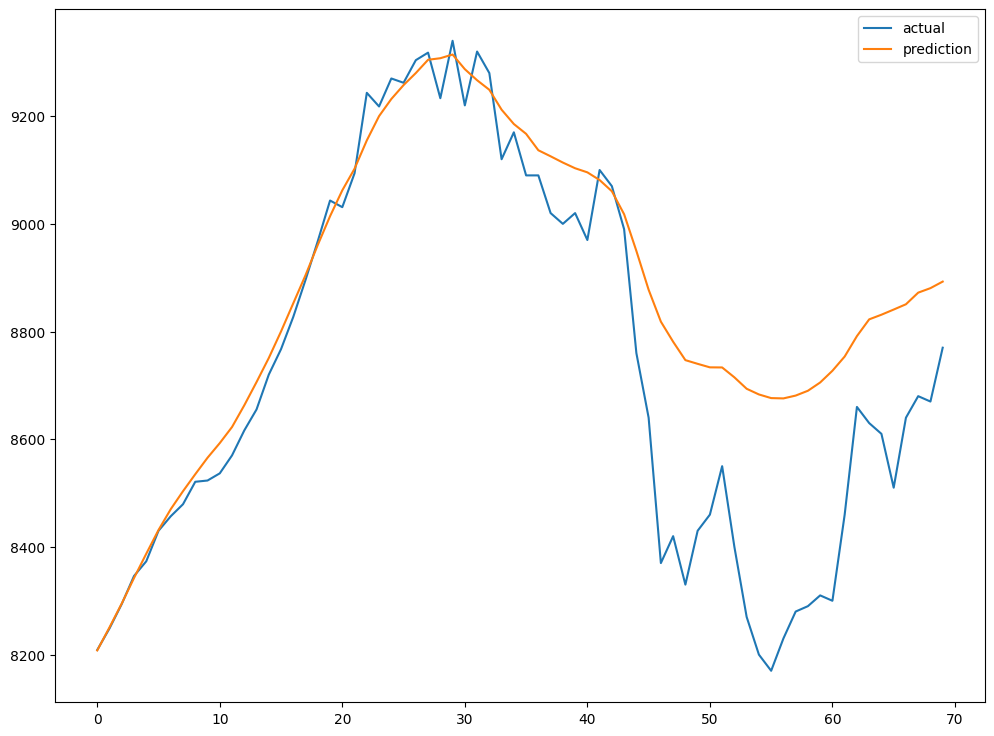

종목코드    A000040
Name: 118, dtype: object
1번째 종목코드
3/3 [==============================] - 1s 16ms/step


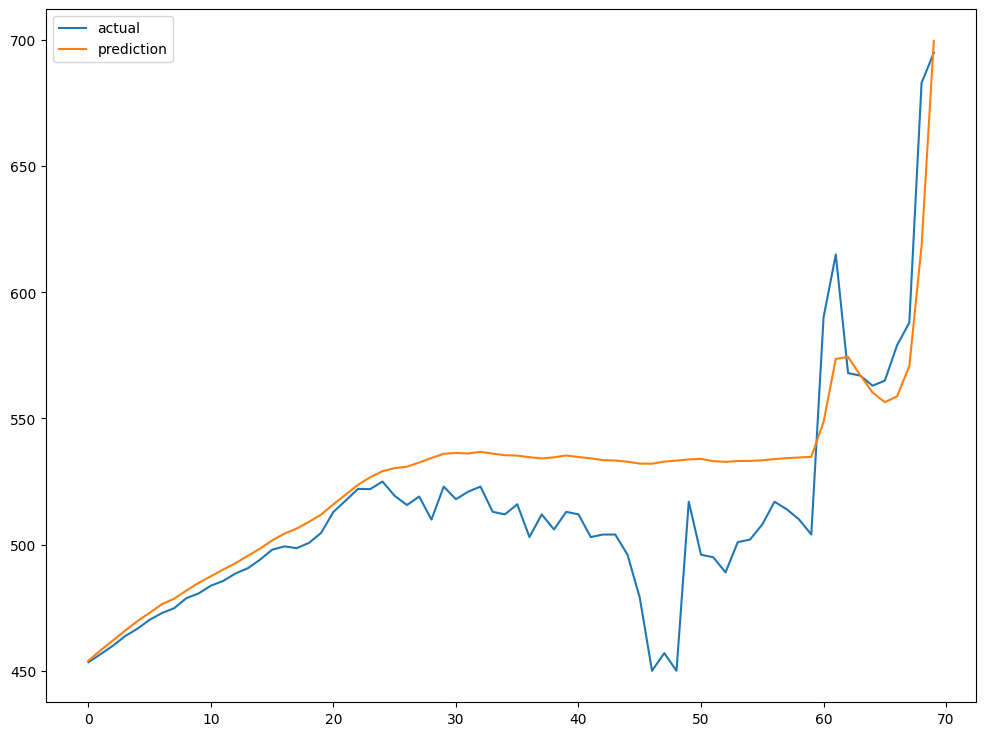

종목코드    A000050
Name: 243, dtype: object
2번째 종목코드
3/3 [==============================] - 1s 19ms/step


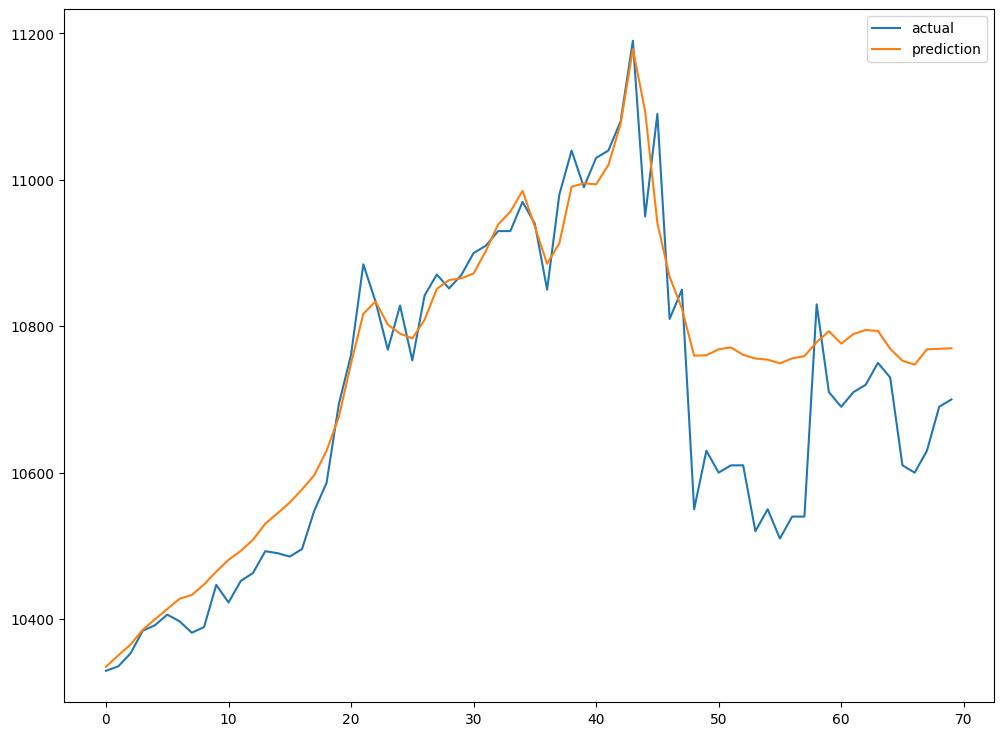

종목코드    A000070
Name: 760, dtype: object
3번째 종목코드


3/3 [==============================] - 2s 23ms/step


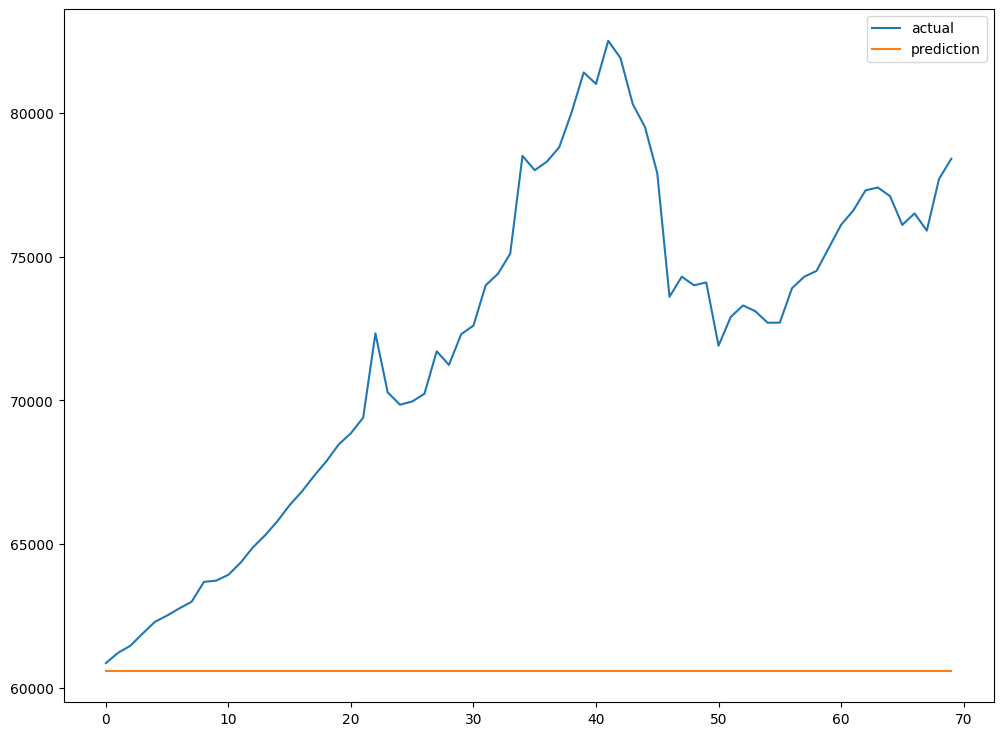

종목코드    A000080
Name: 1803, dtype: object
4번째 종목코드


In [ ]:
idx=0

pred_list=[]
gap_acc=[]
out_labels=[]
for c in sliced_dataframes:
  print(labels.iloc[idx])
  print("{}번째 종목코드".format(idx))
  LSTM_model=LSTM_Object(c)
  gap = LSTM_model.ret_learning()
  idx+=1
  out_labels.append(labels.iloc[idx])
  sleep(2)
  gap_acc.append(gap)
  #to prevent model corrupting

In [12]:
#중간에 멈출 경우 사용 / stopped가 위의 n 번째 종목코드
#이것도 중간에 멈추면 바로 밑에 셀 추가해서 사용하세요 % 위치 달라지지 않게 주의!

stopped=5
idx=stopped
for c in sliced_dataframes[stopped:]:
  print(labels.iloc[idx])
  print("{}번째 종목코드".format(idx))
  LSTM_model=LSTM_Object(c)
  pred,gap = LSTM_model.ret_learning()
  idx+=1
  out_labels.append(labels.iloc[idx])
  sleep(2)
  pred_list.append(pred)
  gap_acc.append(gap)
  #to prevent model corrupting

종목코드    A000100
Name: 1328, dtype: object
5번째 종목코드


KeyboardInterrupt: ignored

In [ ]:
#결과가 이상하게 나올 경우 // 모델 데이터가 많아서 컴퓨터 프로세스 문제니 반복하면 됩니다
#n은 결과가 이상하게 나온 애
n=10
c=sliced_dataframes[n]
LSTM_model=LSTM_Object(c)
gap = LSTM_model.ret_learning()
# 여러개가 있을 경우에는 바로 밑에 셀 추가해서 n 만 바꿔서 사용하세요.